In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training

This treats the spectrograms of the words like images

In [ ]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
# Load the TensorBoard notebook extension - if you want it inline - this can be a bit flaky...
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# clear out any old logs
!rm -rf ./logs/

In [ ]:
# launch tensorboard using this command
# %tensorboard --logdir logs

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# List of the words in categorical order
command_words = [
    'slow',
    'left',
    'right',
    'stop',
    '_invalid',
]

In [ ]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('/content/drive/MyDrive/training_spectrogram.npz')
validation_spectrogram = np.load('/content/drive/MyDrive/validation_spectrogram.npz')
test_spectrogram = np.load('/content/drive/MyDrive/test_spectrogram.npz')

In [ ]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

(array([16640., 18360., 22520., 20920., 50200.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

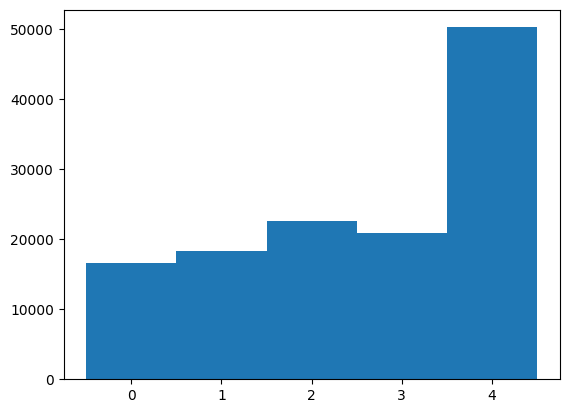

In [ ]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(command_words)+1), align='left')

In [ ]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3 4] [16640 18360 22520 20920 50200]


{'slow': 16640,
 'left': 18360,
 'right': 22520,
 'stop': 20920,
 '_invalid': 50200}

In [ ]:
Y_train = tf.one_hot(Y_train_cats, len(command_words))
Y_validate = tf.one_hot(Y_validate_cats, len(command_words))
Y_test = tf.one_hot(Y_test_cats, len(command_words))

In [ ]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [ ]:
model = Sequential([
    Conv2D(4, 3,
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3,
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(
        80,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dropout(0.1),
    Dense(
        len(command_words),
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D  (None, 49, 21, 4)         0         
 )                                                               
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling3 (MaxPooling2D  (None, 24, 10, 4)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0

In [ ]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/10
4020/4020 [==============================] - 252s 62ms/step - loss: 0.5494 - accuracy: 0.8386 - val_loss: 0.4205 - val_accuracy: 0.8939
Epoch 2/10
4020/4020 [==============================] - 262s 65ms/step - loss: 0.3654 - accuracy: 0.9145 - val_loss: 0.3934 - val_accuracy: 0.9068
Epoch 3/10
4020/4020 [==============================] - 255s 64ms/step - loss: 0.3359 - accuracy: 0.9258 - val_loss: 0.4038 - val_accuracy: 0.9099
Epoch 4/10
4020/4020 [==============================] - 265s 66ms/step - loss: 0.3158 - accuracy: 0.9324 - val_loss: 0.3832 - val_accuracy: 0.9147
Epoch 5/10
4020/4020 [==============================] - 250s 62ms/step - loss: 0.3060 - accuracy: 0.9367 - val_loss: 0.3556 - val_accuracy: 0.9275
Epoch 6/10
4020/4020 [==============================] - 253s 63ms/step - loss: 0.2978 - accuracy: 0.9388 - val_loss: 0.3315 - val_accuracy: 0.9303
Epoch 7/10
4020/4020 [==============================] - 252s 63ms/step - loss: 0.2913 - accuracy: 0.9416 - val_loss: 0

In [ ]:
model.save("/content/drive/MyDrive/trained.model")

# Testing the Model

In [ ]:
model2 =  keras.models.load_model("/content/drive/MyDrive/trained.model")

In [ ]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

127/127 [==============================] - 12s 92ms/step - loss: 0.2861 - accuracy: 0.9470


In [ ]:
predictions = model2.predict(X_test, 128)

127/127 [==============================] - 12s 91ms/step


In [ ]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

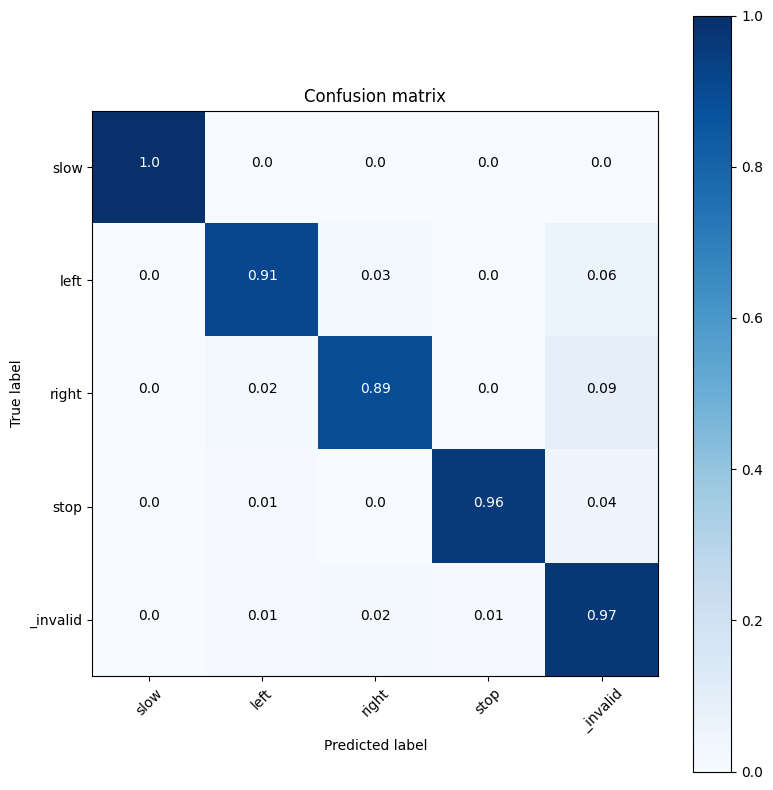

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

In [ ]:
import shutil

# Define paths
source_folder = "trained.model"
destination_folder = "/content/drive/MyDrive/train.model"

# Copy folder to Google Drive
shutil.copytree(source_folder, destination_folder)


'/content/drive/MyDrive/train.model'

# Fully train the model

In [ ]:
import numpy as np

In [ ]:
batch_size = 30
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(len(complete_train_X)).batch(batch_size)

In [ ]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
1848/5361 [=========>....................] - ETA: 3:31 - loss: 0.2854 - accuracy: 0.9399

In [ ]:
model2.save("fully_trained.model")

In [ ]:
results = model2.evaluate(complete_train_X, tf.cast(complete_train_Y, tf.float32), batch_size=128)

In [ ]:
predictions = model2.predict(complete_train_X, 128)

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(complete_train_Y, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

In [ ]:
training_spectrogram = np.load('/content/drive/MyDrive/training_spectrogram.npz')
validation_spectrogram = np.load('/content/drive/MyDrive/validation_spectrogram.npz')
test_spectrogram = np.load('/content/drive/MyDrive/test_spectrogram.npz')

X_train = training_spectrogram['X']
X_validate = validation_spectrogram['X']
X_test = test_spectrogram['X']

complete_train_X = np.concatenate((X_train, X_validate, X_test))
# complete_train_X = X_validate

In [ ]:
converter2 = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/trained.model")
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(0, len(complete_train_X), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [complete_train_X[i:i+100]]
converter2.representative_dataset = representative_dataset_gen
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

82352

In [ ]:
!xxd -i converted_model.tflite > model_2.cc